# Basic CNN for traffic sign recognition
## Christian Igel, 2022

This notebook provides a template for a small CNN for the German Traffic Sign Recognition Benchmark. The data is described in:

Johannes Stallkamp, Marc Schlipsing, Jan Salmen, and Christian Igel. Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition. *Neural Networks* **32**, pp. 323-332, 2012

This notebook is a template, without modification the model does not even come close to the state-of-the-art. 

Please [contact me](mailto:igel@diku.dk) if you have suggestions for improving the notebook.

Do the imports first:

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torchvision.datasets.utils import download_url, extract_archive

Check if a GPU is available:

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cpu


The GTSRB data wrapped in a `Dataset`. This is implemented in the file `GTSRBTrafficSigns.py`. Let's import the class:

In [3]:
from GTSRBTrafficSigns import GTSRBTrafficSigns

In [4]:
dataset_train = GTSRBTrafficSigns()

  0%|          | 0/290897892 [00:00<?, ?it/s]

Define the data loader for training:

In [5]:
batch_size = 128
generator_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
print("Number of training patterns:", dataset_train.__len__())

39209


Let's visualize some input images. This visualization is very important, among others to verify that the data augmentation works as expected.

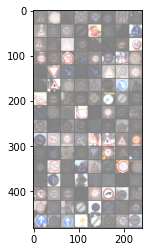

In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(generator_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

Let's look at each image in the batch with its label:

In [ ]:
for i in range(batch_size):
  imshow(images[i])
  print(labels[i].item(), "\n\n")


Define the neural network:

In [ ]:
class Net(nn.Module):
    def __init__(self, img_size=28):
        super(Net, self).__init__()
        # Add code here ....
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        self.fc2 = nn.Linear(in_features=1024, out_features=43, bias=True)
        
    def forward(self, x):
        # And here ...
        x = self.pool1(F.elu(self.conv1(x)))
        x = self.pool2(F.elu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc2(x))
        return x



Instantiate the neural network and potentially move it to GPU:

In [10]:
net = Net()
if(gpu):
  net.to(device)
print(net)

Net()


Define loss and optimization algorithm:

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, eps=0.1)

ValueError: optimizer got an empty parameter list

These lines can be used to continue training:

In [ ]:
cont = False
if cont:
  net.load_state_dict(torch.load('traffic_simple'))

Do the training:

In [ ]:
no_epochs = 200
for epoch in range(no_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(generator_train, 0):
        # Get the inputs; data is a list of [inputs, labels]
        if (gpu):
          inputs, labels = data[0].to(device), data[1].to(device)
        else:
          inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        reporting_interval = 100
        running_loss += loss.item()
        if i % reporting_interval == reporting_interval-1:  # Print every reporting_interval mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / reporting_interval))
            running_loss = 0.0

print('Finished Training')

Evaluate on test set:

In [13]:
dataset_test = GTSRBTrafficSigns(train=False)
generator_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)
print("Number of test patterns:", dataset_test.__len__())

Using existing ./GTSRB/test
Number of test patterns: 12630


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in generator_test:
        if (gpu):
          images, labels = data[0].to(device), data[1].to(device)
        else:
          images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

RuntimeError: The size of tensor a (28) must match the size of tensor b (128) at non-singleton dimension 2

Save network:

In [ ]:
torch.save(net.state_dict(), 'traffic_simple')